In [2]:
!pip install rasterio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 57.0 MB/s eta 0:00:00:00:0100:01


In [3]:
# Connect and verify Data

import os, glob, re, warnings
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import OrderedDict
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler   

warnings.filterwarnings("ignore")
SEED = 42
torch.manual_seed(SEED); np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True          

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

CONFIG = {
    "mask_dir": "/kaggle/input/datasets/pawanshrestha4632/pokharadataset/Pokhara_Dataset/masks",
    "output_dir": "predictions",
    "skip_years": [2018],
    "patch_size": 256,
    "stride": 256,
    "num_classes": 3,
    "ignore_index": 255,
    "seq_len": 4,
    "encoder_channels": [32, 64],
    "convlstm_hidden": 64,
    "convlstm_kernel": 3,
    "dropout": 0.25,
    "batch_size": 4,
    "accum_steps": 2,
    "learning_rate": 3e-4,
    "weight_decay": 1e-4,
    "num_epochs": 60,
    "class_weights": [1.0, 1.0, 5.0],
    "train_cutoff_year": 2023,
    "val_year": 2024,
    "forecast_years": list(range(2025, 2031)),
}

os.makedirs(CONFIG["output_dir"], exist_ok=True)
print("Config ready.")

def parse_mask_filename(fname):
    base = os.path.basename(fname).lower()
    base = os.path.splitext(base)[0]
    base = re.sub(r'^mask_?', '', base)
    m = re.match(r'(\d{4})[_]?(.*)', base)
    if not m:
        raise ValueError(f"Cannot extract year from: {fname}")
    year = int(m.group(1))
    rest = m.group(2).lower()
    if rest.startswith("pre"):
        sord, season = 0, "PreMonsoon"
    elif rest.startswith("post"):
        sord, season = 1, "PostMonsoon"
    else:
        raise ValueError(f"Cannot detect season from: {fname}  (parsed rest='{rest}')")
    label = f"{year}_{'Pre' if sord==0 else 'Post'}Monsoon"
    return year, sord, label

def remap_mask(mask):
    out = np.full_like(mask, 255, dtype=np.uint8)
    out[mask == 1] = 0
    out[mask == 2] = 1
    out[mask == 3] = 2
    return out

files = sorted(glob.glob(os.path.join(CONFIG["mask_dir"], "*.tif")))

parsed = []
for f in files:
    try:
        year, sord, label = parse_mask_filename(f)
    except ValueError:
        print(f"Skipped: {os.path.basename(f)}")
        continue
    if year in CONFIG["skip_years"]:
        continue
    parsed.append((year, sord, label, f))

seen = {}
deduped = []
for item in parsed:
    key = (item[0], item[1])
    if key not in seen:
        seen[key] = item
        deduped.append(item)
parsed = deduped

parsed.sort(key=lambda x: (x[0], x[1]))

timeline, masks_raw, masks_remapped, geo_profiles = [], [], [], []
for year, sord, label, fpath in parsed:
    with rasterio.open(fpath) as src:
        data = src.read(1)
        profile = src.profile.copy()
    timeline.append((year, sord, label))
    masks_raw.append(data)
    masks_remapped.append(remap_mask(data))
    geo_profiles.append(profile)

print(f"Loaded {len(masks_raw)} masks (shape {masks_raw[0].shape})")


Device: cuda
Config ready.
Loaded 12 masks (shape (1337, 2116))


In [4]:
#Manage Dataset

def extract_patches(mask, patch_size, stride):
    H, W = mask.shape
    patches = []
    positions = []
    for y in range(0, H - patch_size + 1, stride):
        for x in range(0, W - patch_size + 1, stride):
            patches.append(mask[y:y+patch_size, x:x+patch_size])
            positions.append((y, x))
    return patches, positions

all_patches = []
patch_positions = None
for mask in masks_remapped:
    patches, positions = extract_patches(mask, CONFIG["patch_size"], CONFIG["stride"])
    all_patches.append(patches)
    if patch_positions is None:
        patch_positions = positions

num_patches = len(all_patches[0])
print(f"Patches per frame: {num_patches}")
print(f"Total frames: {len(all_patches)}")

def to_onehot(patch, num_classes=3):
    out = np.zeros((num_classes, patch.shape[0], patch.shape[1]), dtype=np.float32)
    for c in range(num_classes):
        out[c] = (patch == c)
    return out

def build_sequences(all_patches, timeline, seq_len, train_cutoff, val_year):
    T = len(all_patches)
    P = len(all_patches[0])
    trains, vals = [], []
    for t in range(T - seq_len):
        tgt_idx = t + seq_len
        tgt_year = timeline[tgt_idx][0]
        for p in range(P):
            entry = {
                "inputs": [all_patches[t + k][p] for k in range(seq_len)],
                "target": all_patches[tgt_idx][p],
            }
            if tgt_year <= train_cutoff:
                trains.append(entry)
            elif tgt_year == val_year:
                vals.append(entry)
    return trains, vals

train_seqs, val_seqs = build_sequences(
    all_patches, timeline,
    CONFIG["seq_len"], CONFIG["train_cutoff_year"], CONFIG["val_year"]
)

print(f"Train sequences: {len(train_seqs)}")
print(f"Val sequences: {len(val_seqs)}")

class LandCoverDataset(Dataset):
    def __init__(self, seqs, num_classes=3, augment=False):
        self.seqs = seqs
        self.num_classes = num_classes
        self.augment = augment

    def __len__(self):
        return len(self.seqs)

    def __getitem__(self, idx):
        seq = self.seqs[idx]
        inp = torch.from_numpy(
            np.stack([to_onehot(m, self.num_classes) for m in seq["inputs"]])
        )
        tgt = torch.from_numpy(seq["target"].astype(np.int64))
        if self.augment:
            if np.random.rand() > 0.5:
                inp, tgt = torch.flip(inp, [-1]), torch.flip(tgt, [-1])
            if np.random.rand() > 0.5:
                inp, tgt = torch.flip(inp, [-2]), torch.flip(tgt, [-2])
        return inp, tgt

train_ds = LandCoverDataset(train_seqs, CONFIG["num_classes"], augment=True)
val_ds = LandCoverDataset(val_seqs, CONFIG["num_classes"], augment=False)

train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"],
                          shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=CONFIG["batch_size"],
                        shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_ds)} samples | {len(train_loader)} batches")
print(f"Val: {len(val_ds)} samples | {len(val_loader)} batches")

Patches per frame: 40
Total frames: 12
Train sequences: 240
Val sequences: 80
Train: 240 samples | 60 batches
Val: 80 samples | 20 batches


In [5]:
#Simple ConvLSTM 

class ConvLSTMCell(nn.Module):
    def __init__(self, in_ch, hidden_ch, ks=3):
        super().__init__()
        self.hidden_ch = hidden_ch
        self.gates = nn.Conv2d(in_ch + hidden_ch, 4 * hidden_ch,
                               ks, padding=ks//2, bias=True)

    def forward(self, x, h, c):
        i, f, o, g = self.gates(torch.cat([x, h], 1)).chunk(4, dim=1)
        c_new = torch.sigmoid(f) * c + torch.sigmoid(i) * torch.tanh(g)
        h_new = torch.sigmoid(o) * torch.tanh(c_new)
        return h_new, c_new

    def init_state(self, B, H, W, dev):
        z = torch.zeros
        return z(B, self.hidden_ch, H, W, device=dev), \
               z(B, self.hidden_ch, H, W, device=dev)

class ConvLSTMForecaster(nn.Module):
    def __init__(self, num_classes=3, enc_chs=[32, 64],
                 lstm_h=64, ks=3, dropout=0.25):
        super().__init__()
        layers, ch = [], num_classes
        for out in enc_chs:
            layers += [nn.Conv2d(ch, out, 3, padding=1, bias=False),
                       nn.BatchNorm2d(out), nn.GELU()]
            ch = out
        self.encoder = nn.Sequential(*layers)
        enc_out = enc_chs[-1]
        self.clstm = ConvLSTMCell(enc_out, lstm_h, ks)
        self.dropout = nn.Dropout2d(dropout)
        self.decoder = nn.Sequential(
            nn.Conv2d(lstm_h + enc_out, lstm_h, 3, padding=1, bias=False),
            nn.BatchNorm2d(lstm_h), nn.GELU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(lstm_h, lstm_h // 2, 3, padding=1, bias=False),
            nn.BatchNorm2d(lstm_h // 2), nn.GELU(),
            nn.Conv2d(lstm_h // 2, num_classes, 1),
        )

    def forward(self, x):
        B, T, C, H, W = x.shape
        h, c = self.clstm.init_state(B, H, W, x.device)
        last_e = None
        for t in range(T):
            e = self.encoder(x[:, t])
            h, c = self.clstm(e, h, c)
            h = self.dropout(h)
            last_e = e
        return self.decoder(torch.cat([h, last_e], 1))

model = ConvLSTMForecaster(
    num_classes=CONFIG["num_classes"],
    enc_chs=CONFIG["encoder_channels"],
    lstm_h=CONFIG["convlstm_hidden"],
    ks=CONFIG["convlstm_kernel"],
    dropout=CONFIG["dropout"],
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {total_params:,}")

with torch.no_grad():
    dummy = torch.zeros(1, CONFIG["seq_len"], CONFIG["num_classes"],
                        CONFIG["patch_size"], CONFIG["patch_size"]).to(device)
    assert model(dummy).shape == (
        1, CONFIG["num_classes"],
        CONFIG["patch_size"], CONFIG["patch_size"]
    )



Parameters: 407,107


In [6]:
def compute_metrics(preds, targets, num_classes=3, ignore=255):
    """preds, targets: numpy (N, H, W)"""
    cls     = ["Water", "Vegetation", "Built-up"]
    valid   = targets != ignore
    acc     = ((preds == targets) & valid).sum() / valid.sum() if valid.sum() else 0.0
    ious, vi = {}, []
    for c in range(num_classes):
        pc = (preds == c) & valid
        tc = (targets == c) & valid
        inter = (pc & tc).sum()
        union = (pc | tc).sum()
        iou   = inter / union if union > 0 else float("nan")
        ious[cls[c]] = iou
        if not np.isnan(iou): vi.append(iou)
    ious["mIoU"] = float(np.mean(vi)) if vi else float("nan")
    return float(acc), ious

In [9]:
#Training (AMP + gradient accumulation)

weights   = torch.tensor(CONFIG["class_weights"], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=CONFIG["ignore_index"])
optimizer = torch.optim.AdamW(model.parameters(),
                               lr=CONFIG["learning_rate"],
                               weight_decay=CONFIG["weight_decay"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer, T_max=CONFIG["num_epochs"], eta_min=1e-6)
scaler    = GradScaler()   # AMP scaler


def run_epoch(model, loader, criterion, optimizer, scaler, training, accum=1):
    model.train() if training else model.eval()
    total_loss  = 0.0
    all_preds, all_tgts = [], []
    optimizer.zero_grad()

    for step, (inputs, targets) in enumerate(loader):
        inputs  = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        with autocast():
            logits = model(inputs)
            loss   = criterion(logits, targets) / accum

        if training:
            scaler.scale(loss).backward()
            if (step + 1) % accum == 0 or (step + 1) == len(loader):
                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

        total_loss += loss.item() * accum * inputs.size(0)
        all_preds.append(logits.argmax(1).cpu().numpy())
        all_tgts.append(targets.cpu().numpy())

    preds   = np.concatenate(all_preds)
    tgts    = np.concatenate(all_tgts)
    avg_los = total_loss / len(loader.dataset)
    acc, ious = compute_metrics(preds, tgts, CONFIG["num_classes"], CONFIG["ignore_index"])
    return avg_los, acc, ious


best_miou  = 0.0
best_state = None
history    = {k: [] for k in ["tl","vl","ta","va","tm","vm","ti","vi"]}

print("=" * 72)
print("TRAINING  (AMP + gradient accumulation)")
print("=" * 72)

for epoch in range(1, CONFIG["num_epochs"] + 1):
    tl, ta, ti = run_epoch(model, train_loader, criterion, optimizer, scaler,
                           training=True, accum=CONFIG["accum_steps"])
    vl, va, vi = run_epoch(model, val_loader,   criterion, optimizer, scaler,
                           training=False)
    scheduler.step()

    for k, v in zip(["tl","vl","ta","va","tm","vm","ti","vi"],
                    [tl, vl, ta, va, ti["mIoU"], vi["mIoU"], ti, vi]):
        history[k].append(v)

    mark = ""
    if vi["mIoU"] > best_miou:
        best_miou  = vi["mIoU"]
        best_state = deepcopy(model.state_dict())
        mark       = " ★"

    print(f"Ep {epoch:3d}/{CONFIG['num_epochs']} | "
          f"Loss tr={tl:.4f} va={vl:.4f} | "
          f"Acc  tr={ta:.3f} va={va:.3f} | "
          f"mIoU tr={ti['mIoU']:.3f} va={vi['mIoU']:.3f}{mark}")

    if epoch % 10 == 0:
        print(f"         Val IoU → W:{vi['Water']:.3f} "
              f"Veg:{vi['Vegetation']:.3f} BU:{vi['Built-up']:.3f}")

    # free cache every 5 epochs
    if epoch % 5 == 0:
        torch.cuda.empty_cache()

model.load_state_dict(best_state)
torch.save(model.state_dict(), os.path.join(CONFIG["output_dir"], "best_convlstm.pth"))
print(f"\n✅ Best Val mIoU = {best_miou:.4f}")


TRAINING  (AMP + gradient accumulation)
Ep   1/60 | Loss tr=0.1369 va=0.1534 | Acc  tr=0.940 va=0.930 | mIoU tr=0.887 va=0.872 ★
Ep   2/60 | Loss tr=0.1367 va=0.1581 | Acc  tr=0.940 va=0.935 | mIoU tr=0.889 va=0.882 ★
Ep   3/60 | Loss tr=0.1316 va=0.1513 | Acc  tr=0.939 va=0.935 | mIoU tr=0.890 va=0.882 ★
Ep   4/60 | Loss tr=0.1335 va=0.1507 | Acc  tr=0.937 va=0.924 | mIoU tr=0.857 va=0.868
Ep   5/60 | Loss tr=0.1296 va=0.1532 | Acc  tr=0.940 va=0.927 | mIoU tr=0.890 va=0.873
Ep   6/60 | Loss tr=0.1320 va=0.1809 | Acc  tr=0.937 va=0.928 | mIoU tr=0.887 va=0.873
Ep   7/60 | Loss tr=0.1292 va=0.1354 | Acc  tr=0.940 va=0.927 | mIoU tr=0.889 va=0.864
Ep   8/60 | Loss tr=0.1273 va=0.1568 | Acc  tr=0.939 va=0.929 | mIoU tr=0.889 va=0.872
Ep   9/60 | Loss tr=0.1295 va=0.1478 | Acc  tr=0.938 va=0.931 | mIoU tr=0.886 va=0.878
Ep  10/60 | Loss tr=0.1233 va=0.1528 | Acc  tr=0.939 va=0.930 | mIoU tr=0.890 va=0.867
         Val IoU → W:0.866 Veg:0.881 BU:0.853
Ep  11/60 | Loss tr=0.1234 va=0.1578 |

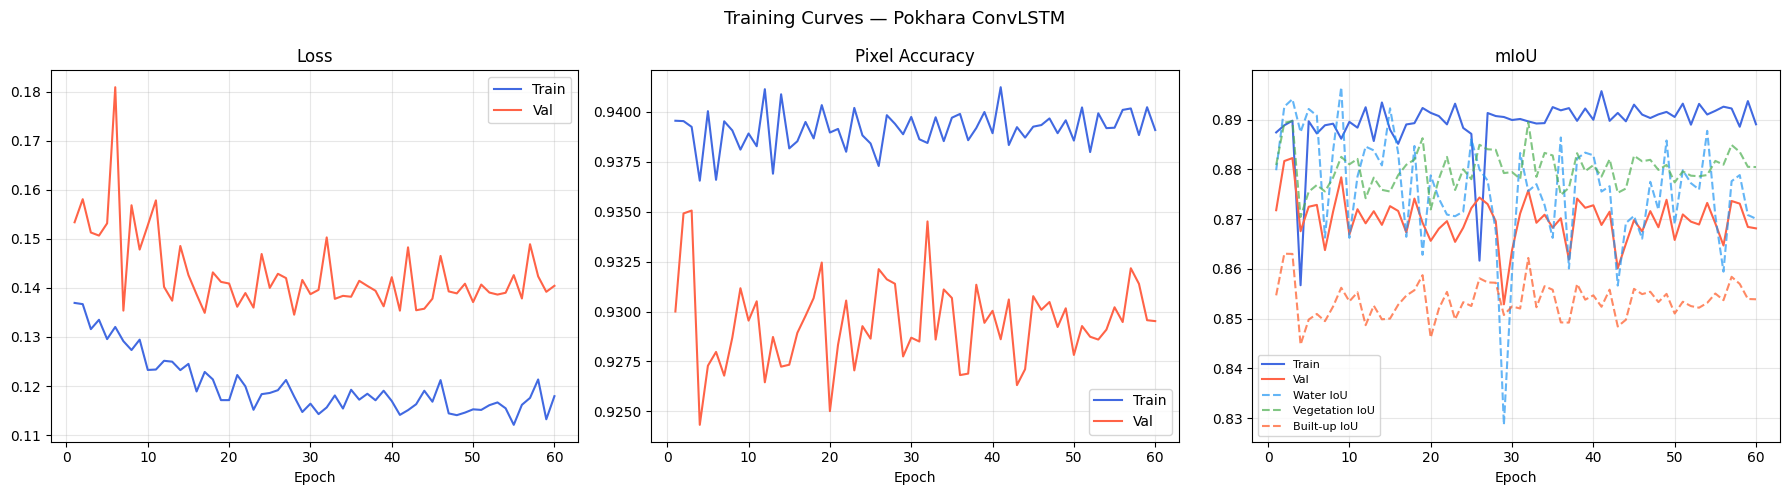

In [10]:
eps = range(1, CONFIG["num_epochs"]+1)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Training Curves — Pokhara ConvLSTM", fontsize=13)

for ax, (tr, va, title) in zip(axes, [
    (history["tl"], history["vl"], "Loss"),
    (history["ta"], history["va"], "Pixel Accuracy"),
    (history["tm"], history["vm"], "mIoU"),
]):
    ax.plot(eps, tr, label="Train", color="royalblue")
    ax.plot(eps, va, label="Val",   color="tomato")
    ax.set_title(title); ax.set_xlabel("Epoch")
    ax.legend(); ax.grid(alpha=0.3)

# per-class val IoU on 3rd panel
for cls, col in zip(["Water","Vegetation","Built-up"], ["#2196F3","#4CAF50","#FF5722"]):
    axes[2].plot(eps, [e[cls] for e in history["vi"]],
                 linestyle="--", alpha=0.7, color=col, label=f"{cls} IoU")
axes[2].legend(fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG["output_dir"], "training_curves.png"), dpi=150)
plt.show()


In [11]:
#AutoRegressive Forecast

def predict_full_mask_safe(model, win_patches, patch_positions,
                           full_shape, patch_size, num_classes, dev, bs=8):
    """Reconstructs full mask using averaged softmax over patches."""
    model.eval()
    H, W      = full_shape
    pred_sum  = np.zeros((num_classes, H, W), dtype=np.float32)
    count_map = np.zeros((H, W), dtype=np.float32)
    seq_len   = len(win_patches)
    N         = len(patch_positions)

    with torch.no_grad():
        for s in range(0, N, bs):
            e     = min(s + bs, N)
            batch = np.stack([
                np.stack([to_onehot(win_patches[t][p], num_classes)
                          for t in range(seq_len)])
                for p in range(s, e)
            ])                                              # (B, T, C, H, W)
            with autocast():
                logits = model(torch.from_numpy(batch).to(dev))
            probs  = F.softmax(logits.float(), dim=1).cpu().numpy()
            for i, p in enumerate(range(s, e)):
                y, x = patch_positions[p]
                pred_sum[:, y:y+patch_size, x:x+patch_size] += probs[i]
                count_map[   y:y+patch_size, x:x+patch_size] += 1

    count_map = np.maximum(count_map, 1)
    return (pred_sum / count_map[np.newaxis]).argmax(0).astype(np.uint8)


def inverse_remap(mask):
    out = np.zeros_like(mask, dtype=np.uint8)
    out[mask == 0] = 1; out[mask == 1] = 2; out[mask == 2] = 3
    return out


num_real = len(all_patches)
cur_win  = [all_patches[i] for i in range(num_real - CONFIG["seq_len"], num_real)]

print("Initial window:")
for i, idx in enumerate(range(num_real - CONFIG["seq_len"], num_real)):
    print(f"  [{i}] {timeline[idx][2]}")

future_tl = [(y, s, f"{y}_{'Pre' if s==0 else 'Post'}Monsoon")
             for y in CONFIG["forecast_years"] for s in [0, 1]]

predicted_masks = OrderedDict()
print(f"\n{'='*55}\nAUTOREGRESSIVE ROLLOUT\n{'='*55}")

for year, sord, label in future_tl:
    full_pred = predict_full_mask_safe(
        model, cur_win, patch_positions,
        masks_remapped[0].shape, CONFIG["patch_size"],
        CONFIG["num_classes"], device
    )
    predicted_masks[label] = full_pred

    
    new_patches = [full_pred[y:y+CONFIG["patch_size"], x:x+CONFIG["patch_size"]]
                   for y, x in patch_positions]
    cur_win.pop(0)
    cur_win.append(new_patches)

    
    bp  = int((full_pred == 2).sum())
    pct = 100 * bp / full_pred.size
    print(f"  {label:<28}  Built-up: {bp:>10,} ({pct:.2f}%)")
    torch.cuda.empty_cache()

print(f"\n✅ {len(predicted_masks)} frames predicted")


Initial window:
  [0] 2023_PreMonsoon
  [1] 2023_PostMonsoon
  [2] 2024_PreMonsoon
  [3] 2024_PostMonsoon

AUTOREGRESSIVE ROLLOUT
  2025_PreMonsoon               Built-up:  1,209,995 (42.77%)
  2025_PostMonsoon              Built-up:  1,258,531 (44.49%)
  2026_PreMonsoon               Built-up:  1,311,789 (46.37%)
  2026_PostMonsoon              Built-up:  1,364,102 (48.22%)
  2027_PreMonsoon               Built-up:  1,407,577 (49.75%)
  2027_PostMonsoon              Built-up:  1,451,675 (51.31%)
  2028_PreMonsoon               Built-up:  1,493,544 (52.79%)
  2028_PostMonsoon              Built-up:  1,533,497 (54.20%)
  2029_PreMonsoon               Built-up:  1,571,595 (55.55%)
  2029_PostMonsoon              Built-up:  1,608,238 (56.85%)
  2030_PreMonsoon               Built-up:  1,642,650 (58.06%)
  2030_PostMonsoon              Built-up:  1,676,304 (59.25%)

✅ 12 frames predicted


In [12]:
#Save files

import rasterio
ref = geo_profiles[0].copy()
ref.update(dtype=rasterio.uint8, count=1, compress="lzw", nodata=0)

for label, mask_pred in predicted_masks.items():
    out      = np.zeros(masks_raw[0].shape, dtype=np.uint8)
    h_, w_   = mask_pred.shape
    out[:h_, :w_] = inverse_remap(mask_pred)
    fpath    = os.path.join(CONFIG["output_dir"], f"Predicted_{label}.tif")
    with rasterio.open(fpath, "w", **ref) as dst:
        dst.write(out, 1)
    print(f"Saved: {fpath}")

Saved: predictions/Predicted_2025_PreMonsoon.tif
Saved: predictions/Predicted_2025_PostMonsoon.tif
Saved: predictions/Predicted_2026_PreMonsoon.tif
Saved: predictions/Predicted_2026_PostMonsoon.tif
Saved: predictions/Predicted_2027_PreMonsoon.tif
Saved: predictions/Predicted_2027_PostMonsoon.tif
Saved: predictions/Predicted_2028_PreMonsoon.tif
Saved: predictions/Predicted_2028_PostMonsoon.tif
Saved: predictions/Predicted_2029_PreMonsoon.tif
Saved: predictions/Predicted_2029_PostMonsoon.tif
Saved: predictions/Predicted_2030_PreMonsoon.tif
Saved: predictions/Predicted_2030_PostMonsoon.tif


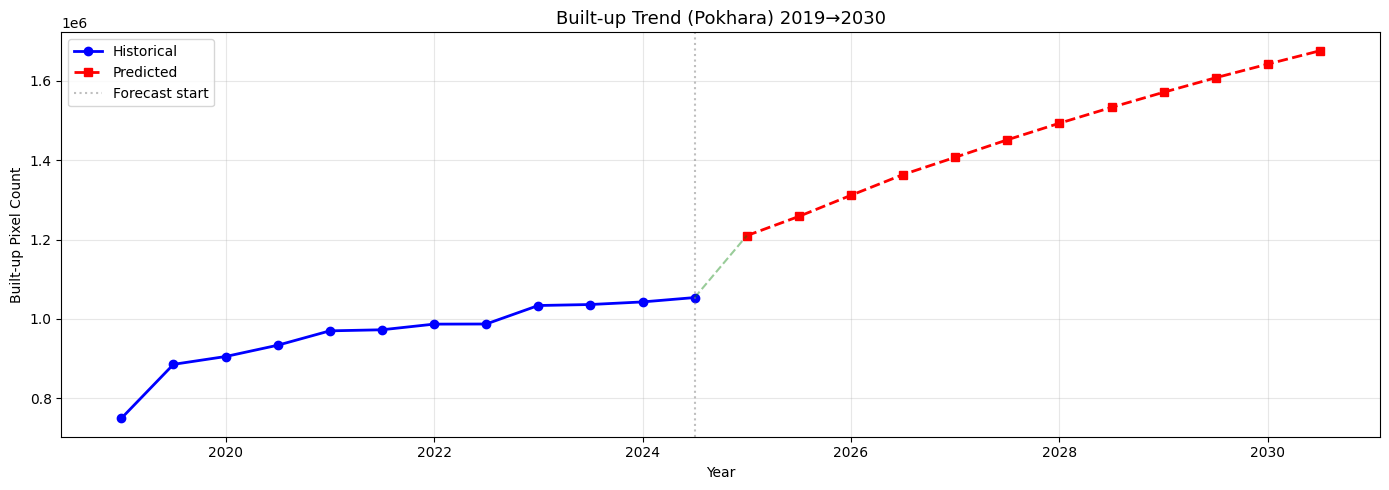


Annual built-up growth (Post→Post):
  2025_PostMonsoon → 2026_PostMonsoon: +8.39%
  2026_PostMonsoon → 2027_PostMonsoon: +6.42%
  2027_PostMonsoon → 2028_PostMonsoon: +5.64%
  2028_PostMonsoon → 2029_PostMonsoon: +4.87%
  2029_PostMonsoon → 2030_PostMonsoon: +4.23%

FINAL SUMMARY
Best epoch    : 3/60
Val Loss      : 0.1513
Val Accuracy  : 0.9351
Val mIoU      : 0.8823
  Water       : 0.8941
  Vegetation  : 0.8897
  Built-up    : 0.8630
Parameters    : 407,107
AMP           : enabled
Grad accum    : 2x  (eff. batch=8)


In [13]:
#Training Summary


hist_bu = {timeline[i][2]: int((masks_remapped[i]==2).sum())
           for i in range(len(timeline))}
pred_bu = {l: int((m==2).sum()) for l, m in predicted_masks.items()}

def to_xf(label):
    y = int(label.split("_")[0])
    return y + (0.0 if "Pre" in label else 0.5)

all_labels = list(hist_bu) + list(pred_bu)
all_vals   = list(hist_bu.values()) + list(pred_bu.values())
x_vals     = [to_xf(l) for l in all_labels]
split      = len(hist_bu)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(x_vals[:split], all_vals[:split], "b-o", lw=2, label="Historical")
ax.plot(x_vals[split:], all_vals[split:], "r--s", lw=2, label="Predicted")
ax.plot([x_vals[split-1], x_vals[split]], [all_vals[split-1], all_vals[split]],
        "g--", alpha=0.4)
ax.axvline(x=2024.5, color="gray", linestyle=":", alpha=0.5, label="Forecast start")
ax.set_title("Built-up Trend (Pokhara) 2019→2030", fontsize=13)
ax.set_xlabel("Year"); ax.set_ylabel("Built-up Pixel Count")
ax.legend(); ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(CONFIG["output_dir"], "builtup_trend.png"), dpi=150)
plt.show()

# Annual growth rates
post_labels = [l for l in pred_bu if "Post" in l]
post_vals   = [pred_bu[l] for l in post_labels]
print("\nAnnual built-up growth (Post→Post):")
for i in range(1, len(post_vals)):
    if post_vals[i-1]:
        g = 100 * (post_vals[i] - post_vals[i-1]) / post_vals[i-1]
        print(f"  {post_labels[i-1]} → {post_labels[i]}: {g:+.2f}%")

# Summary
best_ep   = int(np.argmax(history["vm"]))
best_vi   = history["vi"][best_ep]
print(f"\n{'='*60}")
print(f"FINAL SUMMARY")
print(f"{'='*60}")
print(f"Best epoch    : {best_ep+1}/{CONFIG['num_epochs']}")
print(f"Val Loss      : {history['vl'][best_ep]:.4f}")
print(f"Val Accuracy  : {history['va'][best_ep]:.4f}")
print(f"Val mIoU      : {best_miou:.4f}")
print(f"  Water       : {best_vi['Water']:.4f}")
print(f"  Vegetation  : {best_vi['Vegetation']:.4f}")
print(f"  Built-up    : {best_vi['Built-up']:.4f}")
print(f"Parameters    : {total_params:,}")
print(f"AMP           : enabled")
print(f"Grad accum    : {CONFIG['accum_steps']}x  (eff. batch={CONFIG['batch_size']*CONFIG['accum_steps']})")
print(f"{'='*60}")